# Simulation of the diffraction pattern
This notebook shows how we can create a sample (phase) from atoms and calculate diffraction profiles using both constant wavelength and time-of-flight experiment types.

In [1]:
# esyScience, technique-independent
from easyCore import np

try:
    from easyDiffractionLib import Phase
except ImportError:
    import sys, os
    sys.path.append(os.path.abspath('..'))

# esyScience, diffraction
from easyDiffractionLib import Site, Phase, Phases
from easyDiffractionLib.sample import Sample as Job
from easyDiffractionLib.interface import InterfaceFactory as Calculator
from easyDiffractionLib.Elements.Experiments.Pattern import Pattern1D
from easyDiffractionLib.Profiles.P1D import Instrument1DCWParameters as CWParams
from easyDiffractionLib.Profiles.P1D import Instrument1DTOFParameters as TOFParams
from easyDiffractionLib.Profiles.P1D import Powder1DParameters

# Vizualization
import py3Dmol
import matplotlib.pyplot as plt

GSAS-II binary directory: /Users/andrewsazonov/Development/Projects/easyScience/easyDiffraction/.venv/lib/python3.7/site-packages/GSASII/bindist
ImportError for wx/mpl in GSASIIctrlGUI: ignore if docs build


## --- Sample ---

#### Create an atom using `Site` interface

In [2]:
atom = Site.from_pars(label="Cl",
                      specie="Cl",
                      fract_x=0.0,
                      fract_y=0.0,
                      fract_z=0.0)

#### Create a phase, set space group, add atom

In [3]:
phase = Phase(name="salt")

phase.spacegroup.space_group_HM_name = "F m -3 m"

phase.add_atom(atom)

#### Add another atom (using `Phase` interface)

In [4]:
phase.add_atom('Na', 'Na', 0.5, 0.5, 0.5)

#### Visualise the structure

In [5]:
viewer = py3Dmol.view()
viewer.addModel(phase.to_cif_str(),'cif',{'doAssembly':True,'duplicateAssemblyAtoms':True,'normalizeAssembly':True})
viewer.setStyle({'sphere':{'colorscheme':'Jmol','scale':.2},'stick':{'colorscheme':'Jmol', 'radius': 0.1}})
viewer.addUnitCell()
viewer.replicateUnitCell(2,2,2)
viewer.zoomTo()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

#### Create Phases object

In [6]:
phases = Phases()
phases.append(phase)

## --- Experiment ---

#### Create and modify a `Parameters` object

In [7]:
parameters = CWParams.default()

parameters.length_a = 5.6402
parameters.resolution_u = 0.1447
parameters.resolution_v = -0.4252
parameters.resolution_w = 0.3864
parameters.resolution_x = 0.0
parameters.resolution_y = 0.0

#### Create and modify a Pattern object

In [8]:
pattern = Powder1DParameters.default()

pattern.zero_shift = 0.0
pattern.scale = 100.0

In [9]:
calculator = Calculator(interface_name='CrysPy') # this is the default

In [10]:
print(f"Current calculator engine: {calculator.current_interface_name}")

Current calculator engine: CrysPy


#### Finally, create the job

In [11]:
job_cw = Job(phases=phases, parameters=parameters, calculator=calculator)

Temp CIF: /var/folders/vj/bjjkqpsx4js6s242h0t_h45sf5f66_/T/easydiffraction_temp.cif


In [12]:
print(f"Available calculator engines: {calculator.available_interfaces}")
print(f"Available calculators for CW: {calculator.interface_compatability('Npowder1DCW')}")

Available calculator engines: ['CrysPy', 'CrysFML', 'GSASII']
Available calculators for CW: ['CrysPy', 'CrysFML', 'GSASII']


## --- Analysis ---

#### Calculate the profile using the calculator we defined previously.
Note that we don't run anything on the `Sample` object but on a separate `Calculator` instance

<IPython.core.display.Javascript object>


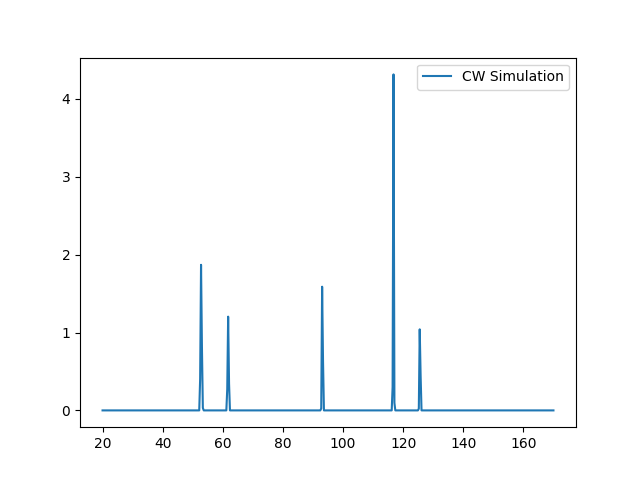

In [13]:
x_data = np.linspace(20, 170, 500)
y_data = calculator.fit_func(x_data)

%matplotlib notebook
plt.plot(x_data, y_data, label='CW Simulation')
plt.legend()

## --- Experiment ---

#### Modify the parameters to correspond to a TOF experiment

In [14]:
parameters = TOFParams.default()

parameters.length_a = 5.6402
parameters.dtt1 = 6167.24700
parameters.dtt2 = -2.28000
parameters.ttheta_bank = 145.00

#### Create new job (TOF) with new parameters, but old phase and calculator objects

In [15]:
job_tof = Job(phases=phases, parameters=parameters, calculator=calculator)

Temp CIF: /var/folders/vj/bjjkqpsx4js6s242h0t_h45sf5f66_/T/easydiffraction_temp.cif


In [16]:
print(f"Available calculator engines: {calculator.available_interfaces}")
print(f"Available calculators for TOF: {calculator.interface_compatability('Npowder1DTOF')}")

Available calculator engines: ['CrysPy', 'CrysFML', 'GSASII']
Available calculators for TOF: ['CrysPy']


## --- Analysis ---

#### Calculate the profile again, this time based on the TOF parameters

<IPython.core.display.Javascript object>


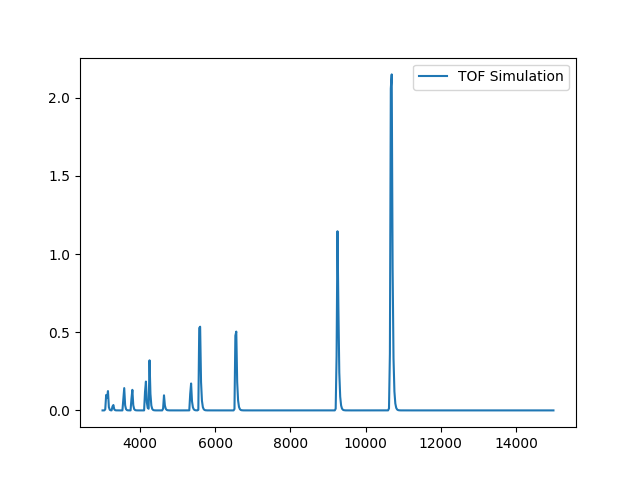

In [17]:
x_data = np.linspace(3000, 15000, 500)
y_data = calculator.fit_func(x_data)

%matplotlib notebook
plt.plot(x_data, y_data, label='TOF Simulation')
plt.legend()